In [2]:
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

# Try reading the file with a different encoding, such as 'latin1'
try:
    data = pd.read_csv('/Users/jmframe/wgi_feb2012.csv', encoding='latin1')
except UnicodeDecodeError as e:
    print("Error reading the file with latin1 encoding:", e)

# Check the data to ensure it's read correctly
print(data.head())

  wgi_glacier_id political_unit  continent_code drainage_code  \
0   AF5Q112B0009             AF               5          Q112   
1   AF5Q112C0025             AF               5          Q112   
2   AF5Q112C0085             AF               5          Q112   
3   AF5Q112C0146             AF               5          Q112   
4   AF5Q112C0151             AF               5          Q112   

  free_position_code local_glacier_code glacier_name     lat     lon  easting  \
0                 B0                009          NaN  34.807  68.891      NaN   
1                 C0                025          NaN  35.438  69.552      NaN   
2                 C0                085          NaN  35.869  70.224      NaN   
3                 C0                146          NaN  35.458  70.023      NaN   
4                 C0                151          NaN  35.409  69.959      NaN   

   ...  area_exp mean_width  mean_length  max_length  max_length_exp  \
0  ...       NaN        NaN          NaN         1

In [11]:
data.columns

Index(['wgi_glacier_id', 'political_unit', 'continent_code', 'drainage_code',
       'free_position_code', 'local_glacier_code', 'glacier_name', 'lat',
       'lon', 'easting', 'northing', 'coordinate_description', 'num_basins',
       'topo_year', 'topo_scale', 'photo_year', 'max_elev', 'mean_elev',
       'min_elev', 'min_elev_exp', 'mean_elev_acc', 'mean_elev_abl',
       'primary_class', 'form', 'frontal_char', 'longi_profile',
       'source_nourish', 'tongue_activity', 'moraines1', 'moraines2',
       'period_activity_start', 'period_activity_end', 'snow_line_elev',
       'snow_line_acy', 'snow_line_date', 'mean_depth', 'depth_acy',
       'total_area', 'area_acy', 'area_in_state', 'area_exp', 'mean_width',
       'mean_length', 'max_length', 'max_length_exp', 'max_length_abl',
       'orientation_acc', 'orientation_abl', 'data_contributor', 'remarks'],
      dtype='object')

In [13]:
# Load the data
data = pd.read_csv('/Users/jmframe/wgi_feb2012.csv', encoding='latin1')

# Check for missing values and handle them
print("Before dropping NaNs", data.shape)
data = data.dropna(subset=['lat', 'lon', 'mean_depth'])
print("After dropping NaNs", data.shape)

# Extract relevant columns
latitudes = data['lat']
longitudes = data['lon']
values = data['mean_depth']

Before dropping NaNs (132890, 50)
After dropping NaNs (70071, 50)


In [14]:
data.shape

(70071, 50)

In [15]:
def idw(lat, lon, values, grid_lat, grid_lon, power=2):
    """
    IDW interpolation for given set of geographic coordinates and values.
    """
    grid_values = np.zeros_like(grid_lat)
    for i in range(grid_lat.shape[0]):
        for j in range(grid_lat.shape[1]):
            # Compute distances from the grid point to all data points
            dists = np.sqrt((lat - grid_lat[i, j])**2 + (lon - grid_lon[i, j])**2)
            if np.any(dists == 0):
                grid_values[i, j] = values[dists == 0].iloc[0]
            else:
                # Calculate weights and weighted sum
                weights = 1 / dists**power
                grid_values[i, j] = np.sum(weights * values) / np.sum(weights)
    return grid_values

In [16]:
# Define the interpolation grid
grid_lat, grid_lon = np.meshgrid(
    np.linspace(latitudes.min(), latitudes.max(), 200),
    np.linspace(longitudes.min(), longitudes.max(), 200)
)

# Perform IDW interpolation
grid_values = idw(latitudes, longitudes, values, grid_lat, grid_lon)


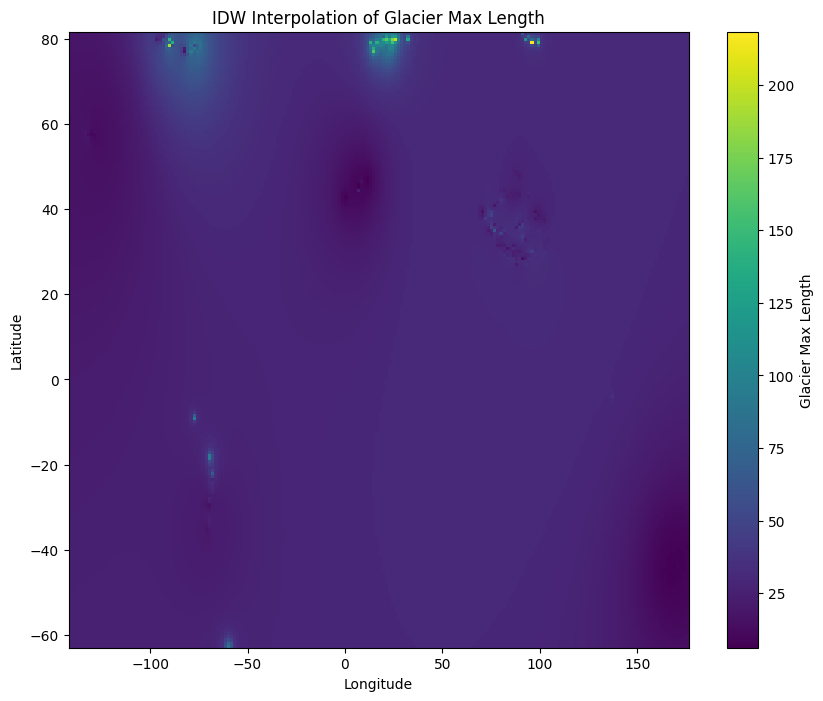

In [17]:
#### 4. Plot the Results

plt.figure(figsize=(10, 8))
plt.pcolormesh(grid_lon, grid_lat, grid_values, shading='auto', cmap='viridis')
plt.colorbar(label='Glacier Max Length')
#plt.scatter(longitudes, latitudes, color='red', s=20)  # Mark original data points
plt.title('IDW Interpolation of Glacier Max Length')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Load the data
data = pd.read_csv('/Users/jmframe/wgi_feb2012.csv', encoding='latin1')
# Drop rows with missing 'mean_depth', 'lat', or 'lon'
data = data.dropna(subset=['mean_depth', 'lat', 'lon'])
# Print the first few rows to understand your data structure (repeat this step to ensure correct column names)
print(data.head())

    wgi_glacier_id political_unit  continent_code drainage_code  \
208   BT5O205C0043             BT               5          O205   
209   BT5O205C0047             BT               5          O205   
210   BT5O205C0095             BT               5          O205   
211   BT5O205D0018             BT               5          O205   
212   BT5O205D0045             BT               5          O205   

    free_position_code local_glacier_code       glacier_name     lat     lon  \
208                 C0                043                NaN  28.024  89.592   
209                 C0                047  Shinchula Glacier  28.091  89.556   
210                 C0                095                NaN  28.077  89.826   
211                 D0                018                NaN  27.961  89.941   
212                 D0                045                NaN  28.155  89.917   

     easting  ...  area_exp mean_width  mean_length  max_length  \
208      NaN  ...       NaN        NaN         1.

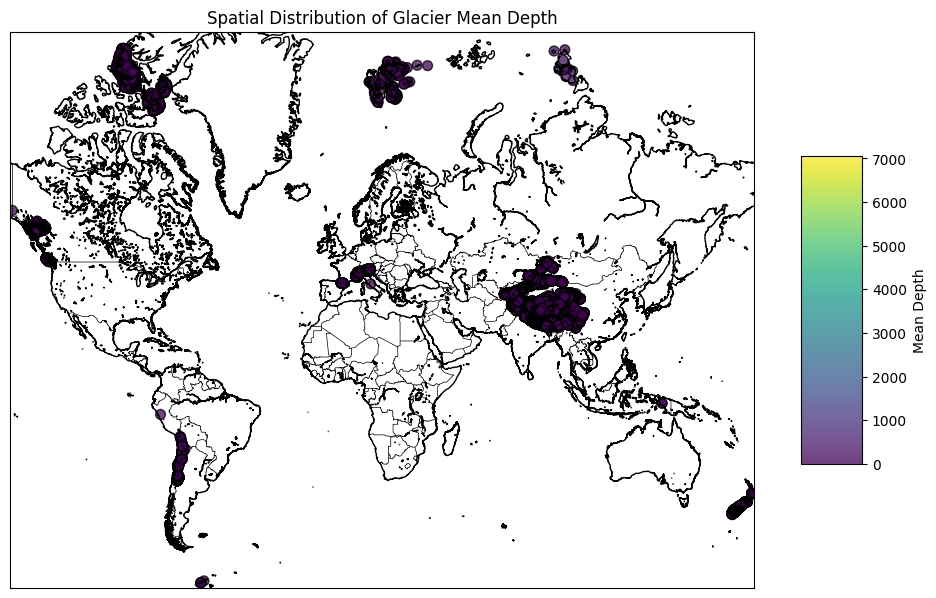

In [3]:
# Set up the plot with Basemap
plt.figure(figsize=(12, 8))
m = Basemap(projection='merc', llcrnrlat=data['lat'].min() - 1, urcrnrlat=data['lat'].max() + 1,
            llcrnrlon=data['lon'].min() - 1, urcrnrlon=data['lon'].max() + 1, lat_ts=20, resolution='i')

# Draw coastlines and countries
m.drawcoastlines()
m.drawcountries()

# Convert lat and lon to map projection coordinates
lons, lats = m(data['lon'].values, data['lat'].values)

# Scatter plot
scatter = m.scatter(lons, lats, c=data['mean_depth'], s=50, cmap='viridis', edgecolor='k', alpha=0.75)

# Add colorbar
cbar = plt.colorbar(scatter, shrink=0.5, aspect=5)
cbar.set_label('Mean Depth')

plt.title('Spatial Distribution of Glacier Mean Depth')
plt.show()